0 = close/last, 1 = open, 2= high, 3 = low
objective: guess the next closing value in the next day

In [29]:

a = 1
b = 2
c= 4
d=7
actual = torch.tensor([a>b, c<d]).float() 
print(actual)

tensor([0., 1.])


In [33]:
import torch
from torch import nn
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import csv
import numpy as np
import tensorflow as tf

with open(r'C:\Users\user\Documents\road to qm\machine learning\pytorch\stock market\NVDA_10.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile))
data = np.array(data)
num_days = data.shape[0]-1
#print(num_days)
#print(data)
#print(data.shape)days = 200
def normalize(n):
    n = 1/(1+np.exp(-n))
    return n
def stock_vector_generator(data, days):
    data = np.delete(data,0,axis = 0) #deletes the top row
    upper_range = np.random.randint(days,num_days) #gives index between days and num_days as a starting point.
    lower_range = upper_range - days
    #closing value the next day - this will be our test data
    next_day_row = data[lower_range-1]
    
   
    #slicing data into small chunks and removing unneccessary rows and columns
    stock_array = data[lower_range:upper_range,:]
    #print(stock_array)
    #print(stock_array.shape)
    #print('Date start: ' + stock_array[-1][0])
    #print('Date end: ' + stock_array[0][0])
    #print('Days: ' + str(days))
    stock_array = np.delete(stock_array, 0, axis = 1)
    stock_array = np.delete(stock_array, 1, axis = 1)
    
    #now to get rid of the dollar sign and change all into floats
    for row in range(stock_array.shape[0]):
        for element in range(stock_array.shape[1]):
            price = stock_array[row][element]
            if price[0] == '$':
                price = price[1:]
            stock_array[row][element] = price
    stock_array = np.array([list( map(float,i) ) for i in stock_array])
    current_price = stock_array[0][0] #obtains the most recent closing price
    #stock_array = np.array([list( map(normalize,i) ) for i in stock_array])
    #now turn into a single lined vector
    stock_vector = stock_array.reshape(days*4,1)
    return stock_vector, next_day_row, current_price

In [34]:
#initializing
days = 10
stock_vector, next_day_row, current_price = stock_vector_generator(data,days)
stock_tensor = torch.from_numpy(stock_vector)
actual = torch.from_numpy(np.array([float(next_day_row[1][1:])])).float()

At 0 step, loss is 0.7559102773666382
At 10 step, loss is 0.5412355661392212
At 20 step, loss is 0.6019687056541443
At 30 step, loss is 0.7340199947357178
At 40 step, loss is 0.6530686020851135
At 50 step, loss is 0.6345934867858887
At 60 step, loss is 0.6508054733276367
At 70 step, loss is 0.634249210357666
At 80 step, loss is 0.7504143714904785
At 90 step, loss is 0.6531041860580444
At 100 step, loss is 0.7549229860305786
At 110 step, loss is 0.6362903118133545
At 120 step, loss is 0.6375446915626526
At 130 step, loss is 0.7518723011016846
At 140 step, loss is 0.7524199485778809
At 150 step, loss is 0.638365626335144
At 160 step, loss is 0.6391627192497253
At 170 step, loss is 0.6383077502250671
At 180 step, loss is 0.636611819267273
At 190 step, loss is 0.6333935856819153
At 200 step, loss is 0.7403324842453003
At 210 step, loss is 0.6298599243164062
At 220 step, loss is 0.6274837255477905
At 230 step, loss is 0.6241347789764404
At 240 step, loss is 0.6230461597442627
At 250 step, l

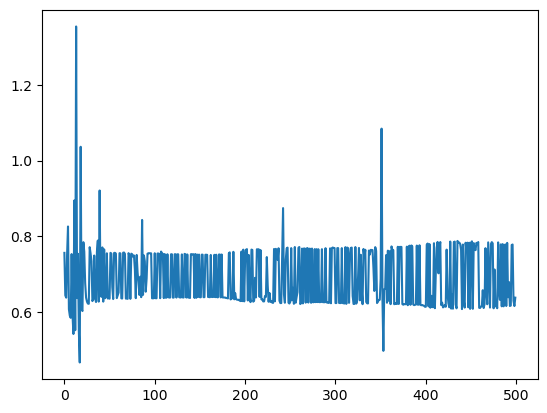

In [171]:
#hyperparameters:
loss_array =[]
days = 10 #control number of days available to the neural network

batch_size = 100 #in huge datasets it is customary to use batch size and updating parameters each batch until it covers the whole 
#dataset each epoch. It is also customary to use powers of 2 for the batch size.

learning_rate = 0.001

n_epoch = 500 #an epoch ends when the whole training set is covered.

input_size = days*4 #I hate tensors

dimensions = {"L0": input_size, "L1": 50, "L2": 10, "L3":10, "L4":2} #number of nodes in each layer, L4 is the output. 10 IS FIXED
class NeuralNetwork(nn.Module):
    def __init__(self, dimensions):
        super(NeuralNetwork, self).__init__()
        self.L1 = nn.Linear(dimensions['L0'], dimensions['L1'])
        self.relu = nn.ReLU()
        self.L2 = nn.Linear(dimensions['L1'], dimensions['L2'])
        self.L3 = nn.Linear(dimensions['L2'], dimensions['L3'])
        self.L4 = nn.Linear(dimensions['L3'], dimensions['L4'])
        self.sigmoid = nn.Sigmoid()
    def forward(self, x): #x is the input
        #3 layers, each with relu except the last layer.
        x = self.L1(x)
        x = self.relu(x)
        x = self.L2(x)
        x = self.relu(x)
        x = self.L3(x)
        x= self.relu(x)
        x = self.L4(x)
        y_predict = self.sigmoid(x)
        return y_predict
model = NeuralNetwork(dimensions)

lossf = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(n_epoch):

    stock_vector, next_day_row, current_price = stock_vector_generator(data,days)
    stock_tensor = torch.from_numpy(stock_vector).float().T  #transpose because pytorch is shit
    next_price = torch.from_numpy(np.array([float(next_day_row[1][1:])])).float()
    
    actual = torch.tensor([next_price>current_price, next_price<current_price]).float() 
    #[1,0] if price rises, [0,1] if price falls 
    
    
    y_predict = model(stock_tensor) #forward prop
    y_predict = y_predict.view(2)    
    loss = lossf(y_predict, actual)
    loss_array.append(loss)
    loss.backward() #backprop
        
    optimizer.step() #update parameters
    optimizer.zero_grad() #resets the gradients
    if epoch % 10 == 0:
        print(f'At {epoch} step, loss is {loss}')
with torch.no_grad():
    
    plt.plot(np.linspace(0,n_epoch-1,num=n_epoch), loss_array)
    

In [43]:
print(actual)

tensor([1., 0.])


In [198]:
with torch.no_grad():
    stock_vector, next_day_row, current_price = stock_vector_generator(data,days)
    stock_tensor = torch.from_numpy(stock_vector).float().T 
    predicted = model(stock_tensor)
    print('prediction: ')
    print(predicted)
    next_price = torch.from_numpy(np.array([float(next_day_row[1][1:])])).float()
    actual = torch.tensor([next_price>current_price, next_price<current_price]).float()
    print(actual)
    

prediction: 
tensor([[0.5369, 0.4557]])
tensor([0., 1.])


Predicted on 09/30/2020 : 
13.250552
Actual was: 
13.5305
2.0690131375100753%
previous price: 13.2258
Price will increase as predicted


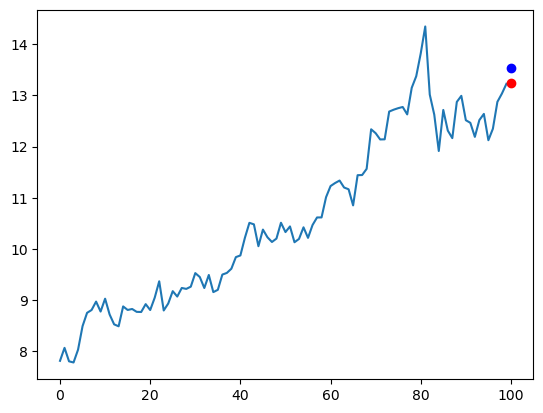

In [39]:
with torch.no_grad():
    stock_vector, next_day_row = stock_vector_generator(data,days)
    stock_tensor = torch.from_numpy(stock_vector).float().T 
    predicted = model(stock_tensor)
    predicted = predicted.numpy()[0][0]
    test_actual = float(next_day_row[1][1:])
    day = next_day_row[0]
    print('Predicted on ' + day + ' : ')
    print(predicted)
    print('Actual was: ')
    print(test_actual)
    diff = 100*((test_actual - predicted)**2)**0.5/test_actual 
    print(str(diff) + '%')
    prev_price = stock_vector[0][0]
    print('previous price: ' + str(prev_price))
    if prev_price > test_actual:
        if prev_price > predicted:
            print('Price will decrease as predicted')
        else:
            print('Directions disagree')
    else:
        if prev_price < predicted:
            print('Price will increase as predicted')
        else:
            print('Directions disagree')
    stock_vector = stock_vector.reshape(days,4)
    stock_vector = stock_vector[:,0]
    plt.plot(np.linspace(0,days-1,num=days),  stock_vector[::-1])
    plt.plot(days,predicted, 'ro', label = 'predicted')
    plt.plot(days,test_actual, 'bo')
